### ML-Based Hybrid Approach for Abrupt Peak Detection in Time-Series Data

###### LOF (Local Outlier Factor) is a machine learning model used for anomaly detection, specifically in unsupervised learning. 
###### It identifies outliers based on the local density of data points.

#### An abrupt spike in PM10 concentration is identified when all three of the following conditions are met:
#### i.	Deviation from Rolling Statistics: 
###### The point exceeds three standard deviations above the rolling mean within a 60-minute window, 
###### ensuring that only sudden, significant deviations from recent trends are flagged.
#### ii.	Density-Based Outlier Detection (LOF): 
###### The point is classified as an outlier by the Local Outlier Factor (LOF) algorithm, 
###### which evaluates anomalies based on local data density, distinguishing true abrupt spikes from gradual fluctuations.
#### iii.	Temporal Recurrence Check: 
###### The detected spike is not part of a recurring event (same hour across multiple days, with a buffer of ±1 hour). 
###### This ensures that systematic daily patterns, such as routine emissions or predictable variations, are not misclassified as abrupt events.


Saved results for Location ID L113 in 'C:/Users/Atique/Spatial3/AbruptPeak_Method2/abrupt_peaks_LOF_Hybrid_L113.xlsx'


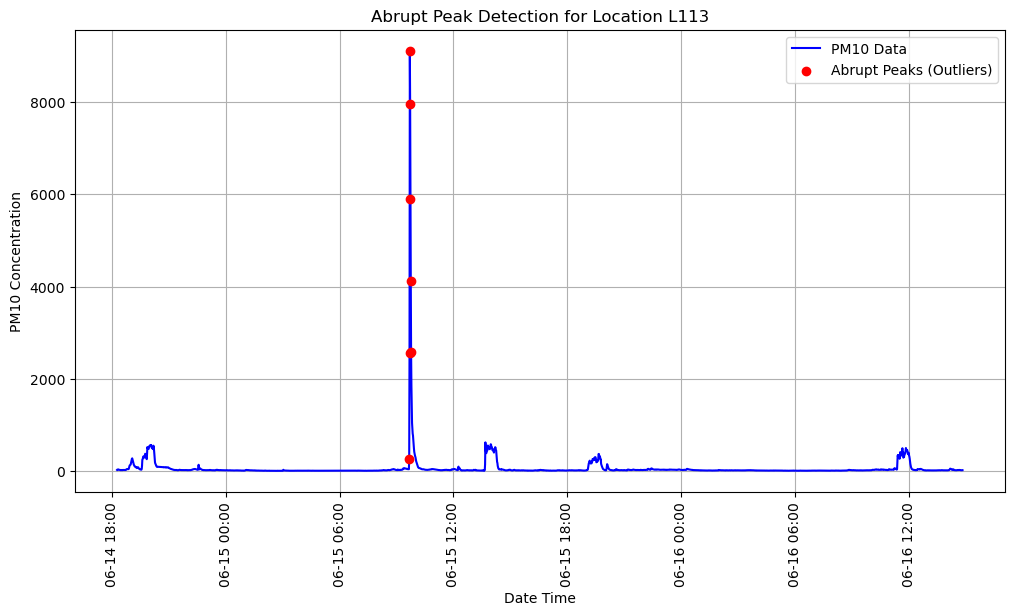

Saved plot for Location ID L113 in 'C:/Users/Atique/Spatial3/AbruptPeak_Method2/abrupt_peaks_plot_L113.png'


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.neighbors import LocalOutlierFactor
import os


save_folder = "C:/Users/Atique/Spatial3/AbruptPeak_Method2/"


df = pd.read_excel("D:/IAQ_data/IAQ_Master_file/Cleaned_Duplicates/Without_Outliers/Abrupt_peak_data_2.xlsx", 
                   parse_dates=["date_time"], sheet_name='L113')

#  Datetime format 
df["date_time"] = pd.to_datetime(df["date_time"])
df = df.sort_values(by=["location_id", "date_time"])


location_ids = df["location_id"].unique()

# -------------- Processing each location_id ------------------
for loc_id in location_ids:
    df_loc = df[df["location_id"] == loc_id].copy()

    # -----------Round timestamps to nearest minute---------------------
    df_loc["date_time"] = df_loc["date_time"].dt.floor("T")  

    #----------------- Extracting hour and day information--------------
    df_loc["hour"] = df_loc["date_time"].dt.hour
    df_loc["day"] = df_loc["date_time"].dt.date

    # --------------Group by exact minutes, keeping pm10 mean and first values for other columns--------------
    df_pm10 = df_loc.groupby("date_time", as_index=False)["pm10"].mean()
    other_columns = df_loc.drop(columns=["pm10"]).drop_duplicates(subset=["date_time"])
    
    df_loc = pd.merge(df_pm10, other_columns, on="date_time", how="left")

    # --------------- Rolling Statistics---------------------------
    window_size = 60  # 1-hour rolling window
    df_loc["rolling_mean"] = df_loc["pm10"].rolling(window=window_size, min_periods=1).mean()
    df_loc["rolling_std"] = df_loc["pm10"].rolling(window=window_size, min_periods=1).std()

    # ----------------------Rolling standard deviation method: 3-sigma rule---------------------
    df_loc["rolling_outlier"] = (df_loc["pm10"] > df_loc["rolling_mean"] + 2 * df_loc["rolling_std"]).astype(int)

    # --------------------------Local Outlier Factor (LOF)-----------------------------
    X = df_loc["pm10"].values.reshape(-1, 1)
    lof = LocalOutlierFactor(n_neighbors=110, contamination=0.005)
    outlier_scores = lof.fit_predict(X)


    df_loc["lof_outlier"] = (outlier_scores == -1).astype(int) # (-1 = outlier, 1 = normal)

    # Hybrid Outliers: Where both LOF & Rolling Std Dev mark an outlier
    df_loc["hybrid_outlier"] = ((df_loc["lof_outlier"] == 1) & (df_loc["rolling_outlier"] == 1)).astype(int)

    # -----------Riser Points (1 point before abrupt peak)
    df_loc["riser"] = df_loc["hybrid_outlier"].shift(-1, fill_value=0)

    # --------- Faller Points (1 point after abrupt peak)
    df_loc["faller"] = df_loc["hybrid_outlier"].shift(1, fill_value=0)


    df_loc["final_outlier"] = df_loc["hybrid_outlier"] | df_loc["riser"] | df_loc["faller"] # Combine Hybrid Outliers, Riser, and Faller Points

   
    outliers = df_loc[df_loc["final_outlier"] == 1].copy() #  # Separate outlier and valid data


    outliers["hour_range"] = outliers["hour"].apply(lambda x: [x - 1, x, x + 1])  #Exclude repeating, Consider one hour before & after
    outlier_counts = outliers.explode("hour_range").groupby("hour_range").nunique()["day"]
    
 
    repeated_hours = outlier_counts[outlier_counts > 1].index # across multiple days

    # Removing recurring abrupt peaks
    df_loc.loc[(df_loc["hour"].isin(repeated_hours)) & (df_loc["final_outlier"] == 1), "final_outlier"] = 0

    valid_data = df_loc[df_loc["final_outlier"] == 0].copy()
    outliers = df_loc[df_loc["final_outlier"] == 1].copy()

    # Identify continuous abrupt peak regions
    outlier_indices = outliers.index.to_list()
    extended_outliers = set(outlier_indices)

    # Add 5 points before & after each continuous outlier block
    window_size = 5  

    for i in range(len(outlier_indices)):
        if i == 0 or outlier_indices[i] != outlier_indices[i - 1] + 1:
            start_idx = max(0, outlier_indices[i] - window_size)
            extended_outliers.update(range(start_idx, outlier_indices[i]))

        if i == len(outlier_indices) - 1 or outlier_indices[i] != outlier_indices[i + 1] - 1:
            end_idx = min(len(df_loc) - 1, outlier_indices[i] + window_size)
            extended_outliers.update(range(outlier_indices[i] + 1, end_idx + 1))

    # Mark extended abrupt peak data
    extended_outlier_df = df_loc.loc[sorted(extended_outliers)].copy()
    extended_outlier_df["final_outlier"] = extended_outlier_df.index.isin(outlier_indices).astype(int) * -1  # -1 for abrupt, 0 for surrounding

    # Saving results for this location_id
    file_name = f"abrupt_peaks_LOF_Hybrid_{loc_id}.xlsx"
    output_path = os.path.join(save_folder, file_name)

    with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
        extended_outlier_df.to_excel(writer, sheet_name="abrupt_peaks", index=False)
        valid_data.to_excel(writer, sheet_name="valid_data", index=False)

    print(f"Saved results for Location ID {loc_id} in '{output_path}'")


    plt.figure(figsize=(12, 6))
    plt.plot(df_loc["date_time"], df_loc["pm10"], label="PM10 Data", color="blue")
    plt.scatter(outliers["date_time"], outliers["pm10"], color="red", label="Abrupt Peaks (Outliers)", zorder=3)


    plt.xlabel("Date Time")
    plt.ylabel("PM10 Concentration")
    plt.title(f"Abrupt Peak Detection for Location {loc_id}")
    plt.legend()
    plt.grid()

    #  x-axis labels
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=90)  


    plot_file = f"abrupt_peaks_plot_{loc_id}.png"
    plot_path = os.path.join(save_folder, plot_file)
    plt.savefig(plot_path, bbox_inches="tight")
    plt.close()

    print(f"Saved plot for Location ID {loc_id} in '{plot_path}'")

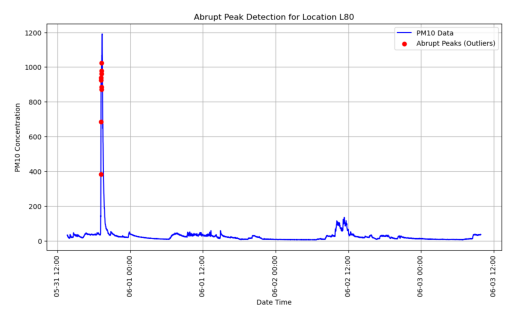

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread("C:/Users/Atique/Spatial3/AbruptPeak_Method2/Abrupt_Peaks_Mod2/abrupt_peaks_plot_L80.png")
plt.imshow(img)
plt.axis("off")  
plt.show()

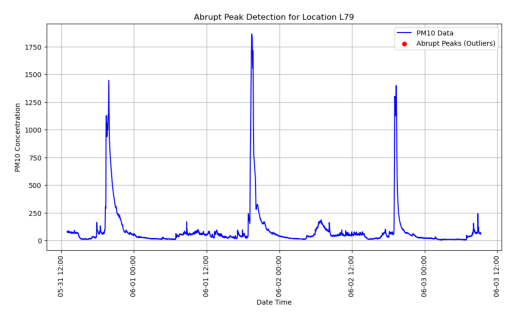

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread("C:/Users/Atique/Spatial3/AbruptPeak_Method2/Abrupt_Peaks_Mod2/abrupt_peaks_plot_L79.png")
plt.imshow(img)
plt.axis("off")  
plt.show()

## Since peaks are recurring at same time, hence not detected as abrupt unrealistic peak